This is a notebook to plot the aspect ratios of all pseduo_labels and its corresponding ground truths. 

In [1]:
import sys
import os

# Add the src directory to the Python path
sys.path.append(os.path.abspath(".."))

In [2]:
import os
from av2.datasets.sensor.av2_sensor_dataloader import AV2SensorDataLoader
from pathlib import Path
from av2.structures.sweep import Sweep
from prototype_utils import (
    filter_gt_labels_by_category,
    extract_face_corners,
    filter_cuboids_by_roi,
    filter_roi,
    bboxes_df_to_numpy_corners)
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import pandas as pd
from av2.structures.cuboid import  CuboidList
from config import CONFIG

[Warning] Since Open3D 0.15, installing Open3D via conda is deprecated. Please re-install Open3D via: `pip install open3d -U`.
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [7]:
home = os.path.join(os.path.expanduser('~'))

dataset_path = Path(os.path.join(home, "dataset", "av2", "train"))

av2 = AV2SensorDataLoader(data_dir=dataset_path, labels_dir=dataset_path)

scene_idx = 1
frame_idx = 0

scene_id = av2.get_log_ids()[scene_idx]
print(f"scene_id: {scene_id}")
frame_id = av2.get_ordered_log_lidar_timestamps(scene_id)[frame_idx]
print(f"frame_id: {frame_id}")
frame_path = av2.get_lidar_fpath_at_lidar_timestamp(scene_id, frame_id)
print(f"frame_path: {frame_path}")

points = Sweep.from_feather(frame_path).xyz

INFO - 2025-01-17 12:43:35,704 - synchronization_database - Building SynchronizationDB


scene_id: 01bb304d-7bd8-35f8-bbef-7086b688e35e
frame_id: 315968867659956000
frame_path: /home/ravi.kumar/dataset/av2/train/01bb304d-7bd8-35f8-bbef-7086b688e35e/sensors/lidar/315968867659956000.feather


We have loaded dataframe of pseudo_labels. Now, we load the gt_labels

In [8]:
def get_all_cuboids_for_a_scene(av2: AV2SensorDataLoader, scene_id: str, config: dict):
    frame_ids = av2.get_ordered_log_lidar_timestamps(scene_id)
    # print(f"Number of frames: {len(frame_ids)}")
    main_lst = []
    for idx, frame_id in  enumerate(frame_ids):
        cuboids = av2.get_labels_at_lidar_timestamp(scene_id, frame_id)
        relevant_cuboids = filter_gt_labels_by_category(cuboids, config)
        # print(relevant_cuboids.cuboids[0])
        main_lst.extend(relevant_cuboids.cuboids)
        # gt_corners = extract_face_corners(relevant_cuboids.vertices_m)
        # gt_corners_roi = filter_cuboids_by_roi(gt_corners, config)

    return CuboidList(main_lst)

all_cuboids_scene = get_all_cuboids_for_a_scene(av2, scene_id, CONFIG)

In [9]:
#all_cuboids_frame = av2.get_labels_at_lidar_timestamp(scene_id, frame_id)

In [10]:
def get_all_cuboids(av2: AV2SensorDataLoader, config: dict):
    scene_ids = av2.get_log_ids()[:config['SCENE_COUNT']]
    main_lst = []
    for scene_id in scene_ids:
        main_lst.extend(get_all_cuboids_for_a_scene(av2, scene_id, config).cuboids)
    return CuboidList(main_lst)
    

all_cuboids = get_all_cuboids(av2, CONFIG)

In [11]:
relevant_cuboids = filter_gt_labels_by_category(all_cuboids, CONFIG)
gt_corners = extract_face_corners(relevant_cuboids.vertices_m)
gt_corners_roi = filter_cuboids_by_roi(gt_corners, CONFIG)

We have the gt_labels for the correct categories in the ROI. Now we simply visualize both of them 

In [ ]:
# from prototype_utils import plot_point_cloud_and_bboxes

# points = Sweep.from_feather(av2.get_lidar_fpath_at_lidar_timestamp(scene_id, frame_id)).xyz
# points_roi = filter_roi(points)
# plot_point_cloud_and_bboxes(points_roi[:,:2], ps_corners)
# plot_point_cloud_and_bboxes(points_roi[:,:2], gt_corners_roi)

NameError: name 'ps_corners' is not defined

If I am to plot aspect ratios of bounding boxes, then I am not limited to ROI, because the aspect ratio of of a gt_lable of a car is the same, whether it is in ROI or not. 


In [13]:
def calc_aspect_ratio_and_area(gt_corners: np.ndarray):
    lst_of_dicts = []
    for cuboid in gt_corners:
        side_1 = np.linalg.norm(cuboid[0] - cuboid[1])
        side_2 = np.linalg.norm(cuboid[1] - cuboid[2])
        side_3 = np.linalg.norm(cuboid[2] - cuboid[3])
        side_4 = np.linalg.norm(cuboid[3] - cuboid[0])
        
        length = max(side_1, side_2, side_3, side_4)
        width = min(side_1, side_2, side_3, side_4)
        aspect_ratio = width / length
        area = length * width
        lst_of_dicts.append({"corners": cuboid,"aspect_ratio": aspect_ratio, "area": area})

    return lst_of_dicts
        
gt_corners_calculated = calc_aspect_ratio_and_area(gt_corners)

In [14]:
areas = [cuboid["area"] for cuboid in gt_corners_calculated]
aspect_ratios = [cuboid["aspect_ratio"] for cuboid in gt_corners_calculated]

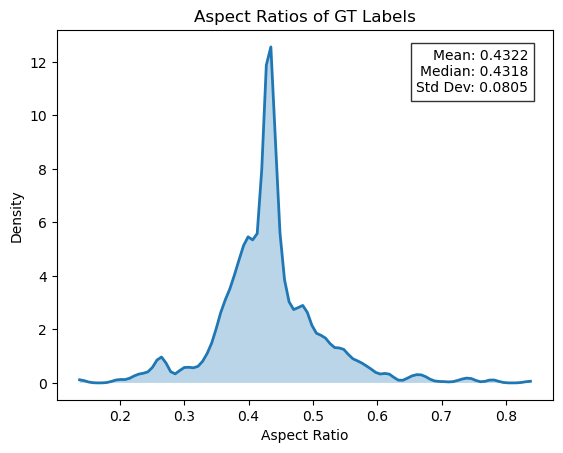

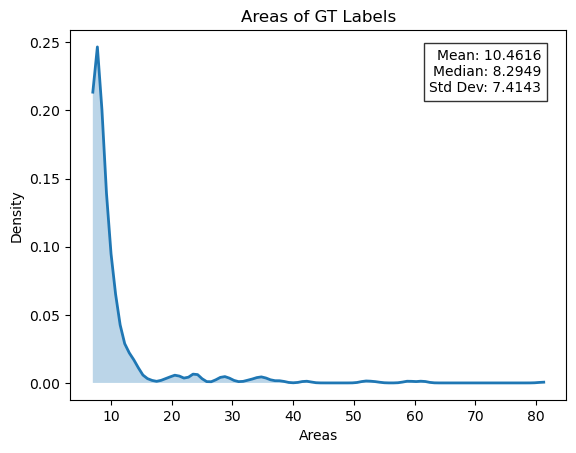

In [33]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

def plot_kde2(aspect_ratios,x_label="Aspect Ratio", title="Aspect Ratios of GT Cuboids"):
    """
    Plots a continuous KDE (Kernel Density Estimate) graph for the given aspect ratios using scipy and matplotlib.
    Also calculates and displays the mean, median, and standard deviation on the plot.
    
    Parameters:
    - aspect_ratios: List of aspect ratios to plot.
    - title: Title of the plot (default is 'Aspect Ratios of GT Cuboids (KDE)').
    """
    # Calculate statistics
    mean_value = np.mean(aspect_ratios)
    median_value = np.median(aspect_ratios)
    std_dev = np.std(aspect_ratios)
    
    # Calculate KDE
    kde = gaussian_kde(aspect_ratios)
    x = np.linspace(min(aspect_ratios), max(aspect_ratios), 100)
    y = kde(x)
    
    # Plot the KDE
    plt.plot(x, y, label="KDE", linewidth=2)
    plt.fill_between(x, y, alpha=0.3)  # Add shading under the curve
    plt.xlabel(x_label)
    plt.ylabel("Density")
    plt.title(title)
    
    # Add statistics as text on the plot
    text_str = (f"Mean: {mean_value:.4f}\n"
                f"Median: {median_value:.4f}\n"
                f"Std Dev: {std_dev:.4f}")
    plt.text(0.95, 0.95, text_str, transform=plt.gca().transAxes,
             fontsize=10, verticalalignment='top', horizontalalignment='right',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

    plt.show()

# Example usage:
# aspect_ratios = [cuboid["aspect_ratio"] for cuboid in gt_corners_calculated]
plot_kde2(aspect_ratios, title="Aspect Ratios of GT Labels")
plot_kde2(areas, x_label="Areas",title="Areas of GT Labels")


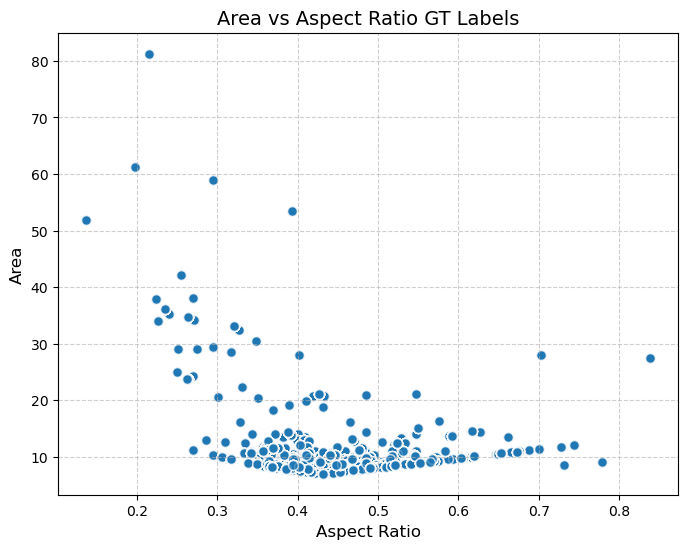

In [32]:
import matplotlib.pyplot as plt
import numpy as np

def plot_area_vs_aspect_ratio(aspect_ratio, area):
    """
    Plots a scatter plot of Area vs Aspect Ratio.

    Parameters:
        aspect_ratio (list or numpy.ndarray): List or array of aspect ratio values.
        area (list or numpy.ndarray): List or array of area values.
    """
    if not isinstance(aspect_ratio, (list, np.ndarray)) or not isinstance(area, (list, np.ndarray)):
        raise ValueError("Both aspect_ratio and area must be lists or numpy arrays.")

    if len(aspect_ratio) != len(area):
        raise ValueError("aspect_ratio and area must have the same length.")

    plt.figure(figsize=(8, 6))
    plt.scatter(aspect_ratio, area, alpha=0.7, edgecolors='w', s=50)

    plt.title("Area vs Aspect Ratio GT Labels", fontsize=14)
    plt.xlabel("Aspect Ratio", fontsize=12)
    plt.ylabel("Area", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

plot_area_vs_aspect_ratio(aspect_ratios, areas)